Libraries

In [1]:
import pandas as pd
from minisom import MiniSom 
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [2]:
%matplotlib inline

Import reservoir data

In [3]:
res = pd.read_csv('res.csv')

Set features as the modelled properties and scale them.

In [4]:
features = res[['SW','phie','GR','ILD','RHOB']]
data=preprocessing.scale(features.values)
feature_names = features.columns

Set m as 5*sqrt(len). Where len is the number of samples for our features.

Note that we use sqrt a 2nd time because we want an n by n matrix, where nxn=m

In [5]:
m=5*np.sqrt(len(features))
n=int(np.sqrt(m))
size = len(feature_names)

som = MiniSom(n, n, size, neighborhood_function='gaussian', sigma=10, random_seed=1,learning_rate=0.5) # Initialization of nxn SOM
som.pca_weights_init(data) #Starting weights from first two Principal Components
som.train_random(data, 1000) #100 training iterations

The weight matrix w is an n x n x f matrix, where f is the number of features.    
As such, w can be thought of as an nxn matrix where each element is a vector of size f.   

In [6]:
w = som.get_weights() #Get weights, this will be a n x n x f tensor where f is the number of features

At the same time, by transposing w, we get a vector of size f where each element is ann nxn weight matrix.

So, in order to plot the neuron response for each feature, we transpose the weights matrix and plot each of the nxn matrixes.

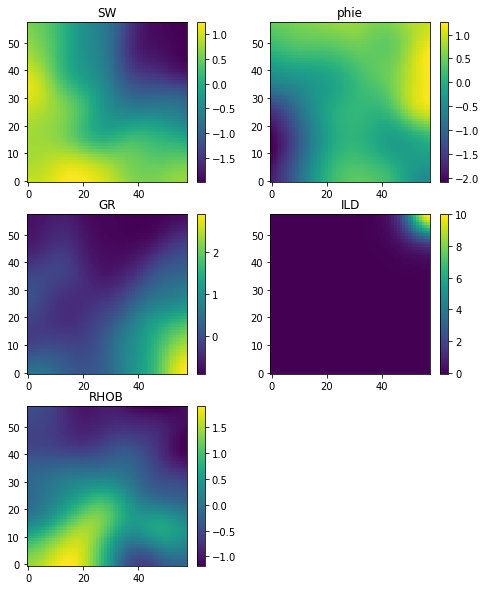

In [9]:
fig = plt.figure(figsize=(8,10))
for i,feat in enumerate(features):
    plt.subplot(3,2,i+1)
    plt.title(feat)
    im = plt.imshow(w.T[i],cmap='viridis',origin='lower')
    plt.colorbar()
#Uncomment to plot distance map at the end
#plt.subplot(3,2,6)
#plt.title('Distance Map')
#im = plt.imshow(som.distance_map(),cmap='viridis',origin='lower')
#plt.colorbar()

In [10]:
#Uncomment to output weights to a csv documment
#output weights
#somdf=[]
#for i,feat in enumerate(features):
#    tempdf=pd.DataFrame(w.T[i])
#    tempdf['feature'] = feat
#    somdf.append(tempdf)
#pd.concat(somdf).to_csv('som.csv')

In order to utilize clustering algoriths on the weights, we need to transform the data into a single features matrix.
As such, by passing x and y position of each neuron and their responses for each feature as columns, we can contruct a l x (f+2) matrix, where is the l is the number of samples and f is the number of features.

By later dropping the x and y columns a sxf matrix is obtained to perform clustering on.

In [10]:
#Make data clusterable
flat = [0]*len(feature_names)
for i,feat in enumerate(features):
    flat[i] = w.T[i].flatten()
flat = pd.DataFrame(flat).T
flat.columns = features.columns

In [11]:
#XY columns for flat dataframe
xs=[]
ys=[]
for x in range(n):
    for y in range(n):
        xs.append(x)
        ys.append(y)
        
flat_xy = flat.copy()
flat_xy['x'] = pd.Series(xs)
flat_xy['y'] = pd.Series(ys)

Define K via Davies-Bouldin Score

In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import *
from sklearn.mixture import GaussianMixture

In [13]:
maxk=10
s_scores=[]
d_scores=[]
krange=range(2,maxk+1)
for k in tqdm(krange):
    kmeans = KMeans(n_clusters=k,init='k-means++')
    predict = kmeans.fit_predict(flat)
    #gmm = GaussianMixture(k)
    #fit = gmm.fit(flat)
    #predict = gmm.predict(flat)
    sill = silhouette_score(flat, predict)
    db = davies_bouldin_score(flat,predict)
    d_scores.append(db)
    s_scores.append(sill)

D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_

([<matplotlib.axis.XTick at 0x1aa85513e48>,
 <a list of 9 Text xticklabel objects>)

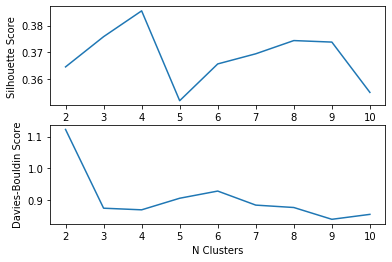

In [14]:
plt.subplot(2,1,1)
plt.plot(krange,s_scores)
plt.ylabel('Silhouette Score')
plt.xticks(krange)
plt.subplot(2,1,2)
plt.plot(krange,d_scores)
plt.ylabel('Davies-Bouldin Score')
plt.xlabel('N Clusters')
plt.xticks(krange)

Setting X and Y for cluster views

In [15]:
X = flat_xy['x']
Y = flat_xy['y']

K-Means Clustering - k=4

In [16]:
k=4
c_map=plt.get_cmap('Set1',k)

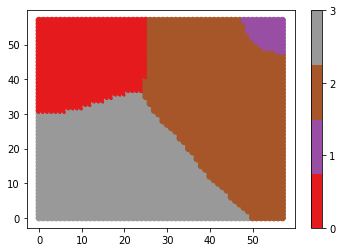

In [18]:
kmeans = KMeans(n_clusters=k,init='k-means++')
predict = kmeans.fit_predict(flat)
Z=predict
plt.scatter(X,Y,c=Z,cmap=c_map)
plt.colorbar(ticks=range(k))
flat_xy['kmeans'] = pd.Series(predict)

Gaussian Mixture Model

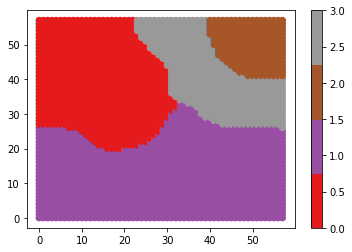

In [20]:
gmm = GaussianMixture(4)
fit = gmm.fit(flat)
gmm_predict = gmm.predict(flat)
flat_xy['gmm']=pd.Series(gmm_predict)
Zg=gmm_predict
plt.scatter(X,Y,c=Zg,cmap=c_map)
plt.colorbar()

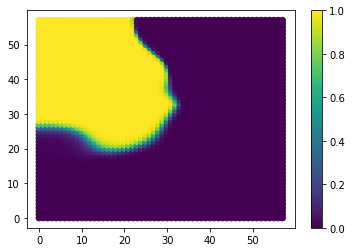

In [21]:
probs=gmm.predict_proba(flat)
for k,labels in enumerate(probs.T):
    flat_xy["gmm "+str(k)] = labels
plt.scatter(X,Y,c=pd.DataFrame(probs).iloc[:,0],cmap='viridis')
plt.colorbar()

Passing the cluster assigned to each Neuron back to each sample in feature space.

In [22]:
pass_df = flat_xy.iloc[:,len(feature_names):]
new_features=[0]*len(features)
for n,sample in tqdm(enumerate(data)):
    x = som.winner(sample)[0]
    y = som.winner(sample)[1]
    new_sample0 = pass_df.loc[pass_df['x'] == x]
    new_sample = new_sample0.loc[new_sample0['y'] == y]
    new_features[n]=np.array(new_sample)[0][2:]

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(new_features).to_csv('csomclusters.csv')